# REGRESIÓN LOGÍSTICA - DATOS German Credit

## Realizado por: Pablo Sánchez Cabrera

# Variables de la base de datos:
- checking_status -> Status of existing checking account, in Deutsche Marks (DM)
- duration (in months) -> Duration in months     
- credit_history -> Credit history (credits taken, paid back duly, delays, critical accounts)
- purpose -> Purpose of the credit (car, television, etc.)                 
- credit_amount -> Credit loan amount, in Deutsche Marks (DM)        
- savings_status -> Status of savings account and bonds, in Deutsche Marks          
- employment -> Present employment, in number of years            
- installment_commitment -> Installment rate in percentage of disposable income
- personal_status -> Personal status (married, single, etc.) and sex
- other_parties -> Other debtors and guarantors      
- residence_since -> Present residence since X years        
- property_magnitude -> Property (e.g., real estate)    
- age -> Age in years                     
- other_payment_plans -> Other installment plans (banks, stores, etc.)       
- housing -> Housing (rent, own, for free)                 
- existing_credits -> Number of existing credits at this bank         
- job -> Job                     
- num_dependents -> Number of people being liable to provide maintenance for          
- own_telephone -> Telephone (yes and no)           
- foreign_worker -> Foreign worker (yes and no)           
- class -> Foreign worker (yes and no)    

Se cargan las librerías:

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
import statsmodels.formula.api as smf  # sintáxis análoga a R
 
from sklearn.metrics import classification_report, confusion_matrix

Se cargan los datos:

In [5]:
datos = pd.read_csv("../data/credit_g.csv", sep=",")

Todas las variables son categóricas salvo:-  duration
-  credit_amount
-  residence_since
-  age
-  existing_credits
-  num_dependentsts


In [6]:
lista_num = ["duration", "credit_amount", "residence_since", "age", "existing_credits", "num_dependents"]

for col in datos.columns:
    if col not in lista_num:
        datos[col] = datos[col].astype("category")

In [7]:
datos.info() #información sobre los registros y variables

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   checking_status         1000 non-null   category
 1   duration                1000 non-null   int64   
 2   credit_history          1000 non-null   category
 3   purpose                 1000 non-null   category
 4   credit_amount           1000 non-null   int64   
 5   savings_status          1000 non-null   category
 6   employment              1000 non-null   category
 7   installment_commitment  1000 non-null   category
 8   personal_status         1000 non-null   category
 9   other_parties           1000 non-null   category
 10  residence_since         1000 non-null   int64   
 11  property_magnitude      1000 non-null   category
 12  age                     1000 non-null   int64   
 13  other_payment_plans     1000 non-null   category
 14  housing                 1

Se plantea un descriptivo de las variables numéricas

In [8]:
datos.describe()

,duration,credit_amount,residence_since,age,existing_credits,num_dependents
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.845000,35.546000,1.407000,1.155000
std,12.058814,2822.736876,1.103718,11.375469,0.577654,0.362086
min,4.000000,250.000000,1.000000,19.000000,1.000000,1.000000
25%,12.000000,1365.500000,2.000000,27.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,33.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,42.000000,2.000000,1.000000
max,72.000000,18424.000000,4.000000,75.000000,4.000000,2.000000


Como la variable `class` es una palabra reservada en Python se reemplaza el nombre de la columna por `target`

In [9]:
# La variable class es una variable reservada en diferentes módulos de Python -> reemplazar por por target
datos.rename(columns={'class': 'target'}, inplace=True)

## Análisis Descriptivo

In [10]:
# Usando pandas de dos formas:
pd.crosstab(datos['target'], columns='frecuencia').apply(lambda p: p/p.sum(), axis=0) #tabla cruzada (en porcentaje)

col_0,frecuencia
target,
bad,0.3
good,0.7


A la vista de los resultados, se observa que la muestra no está balanceada: menos préstamos impagados

También se puede analizar la distribución de variables numéricas según la clase del target:

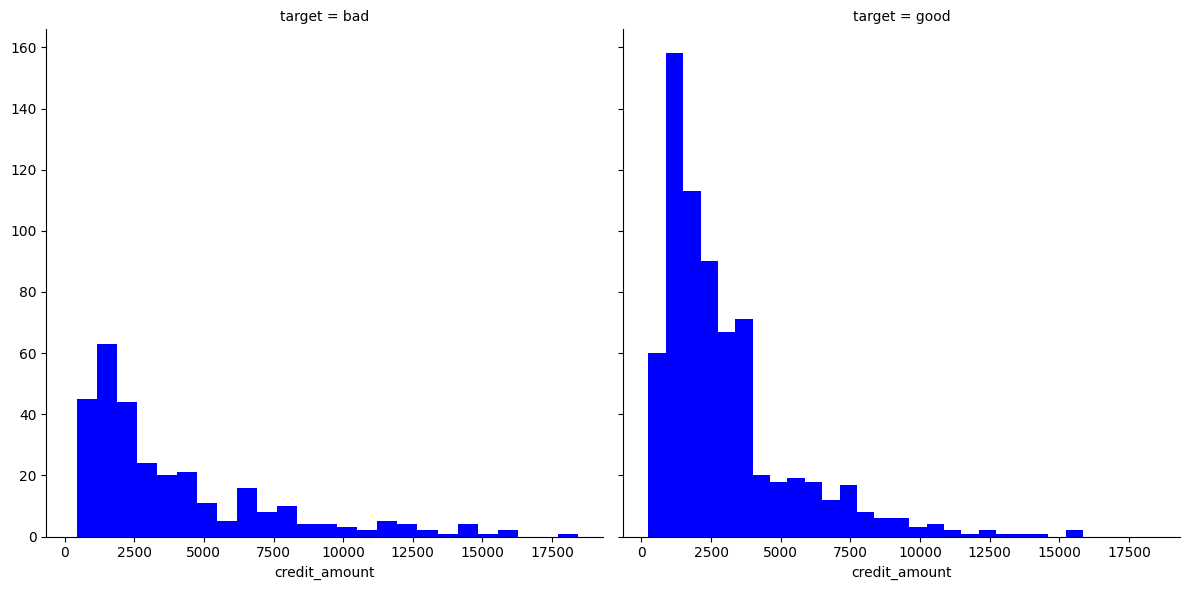

In [11]:
g=sns.FacetGrid(datos, col='target', height=6) #en función de la calidad del préstamo
hist=g.map(plt.hist, 'credit_amount', bins=25, color='blue') #histograma
plt.show()

Puede verse que la mayor parte de préstamos (buenos y malos), son de una cantidad inferior a 2500. Además, se observa que se dan más casos de impago cuanto mayor es la exposición (cantidad del préstamo)

Podemos también analizar cómo es el comportamiento según el uso del préstamo:

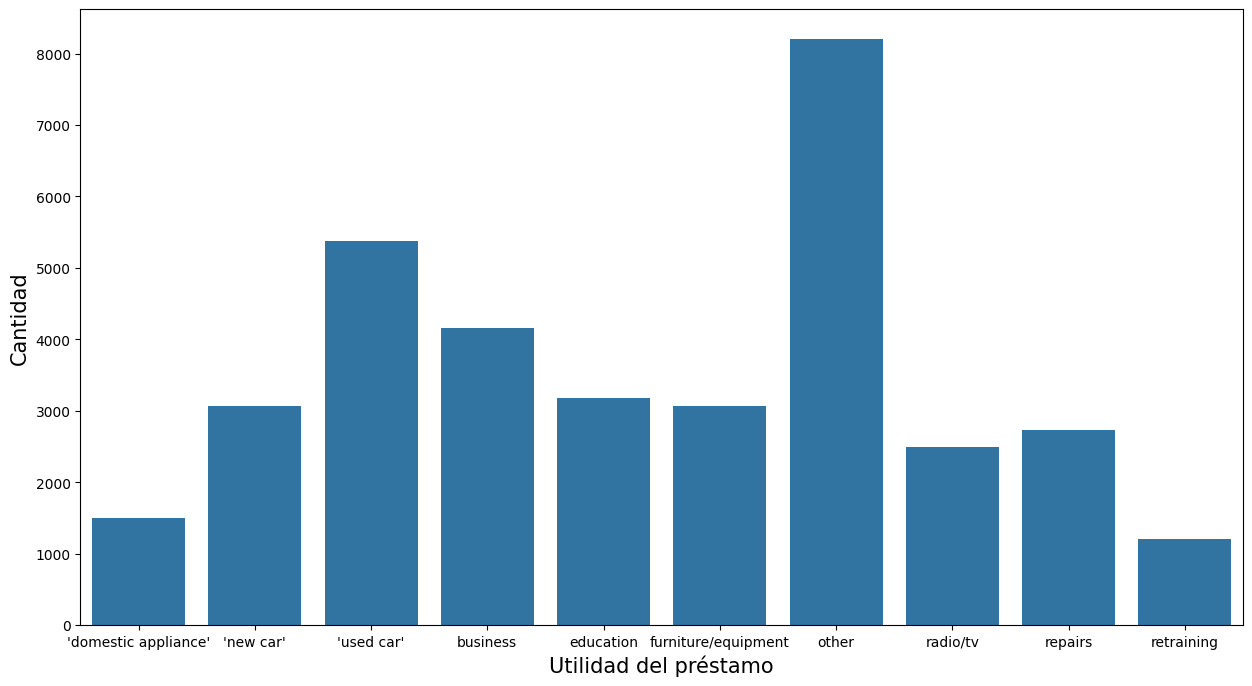

In [12]:
df=pd.DataFrame(datos.groupby('purpose', observed=False)['credit_amount'].mean()).reset_index() #data.frame media por grupos
plt.figure(figsize=(15,8)) #tamaño del gráfico
barplot = sns.barplot(x='purpose', y='credit_amount', data=df) 
barplot.set_xlabel('Utilidad del préstamo', fontsize=15)
barplot.set_ylabel('Cantidad', fontsize=15)
plt.show()

El gráfico nos muestra que la compra de un coche (usado) se encuentra en segundo lugar (a la hora de pedir un préstamo).
Posiblemente, la mayor parte de la gente que compra un coche nuevo tiene liquidez para financiar su compra.



Podemos también hacernos algunas preguntas como: **¿Impagan más las mujeres o los hombres?**
Para responder a la cuestión, se crea un nuevo df que contiene persona_status y class. A partir de éste se genera la nueva variable (dividiendo male y famele la primera varible)

In [13]:
var = ['personal_status', 'target']
df = datos.loc[:, var]
df['sex'] = df['personal_status'].str.split(" ", n = 1, expand = True)[0]  #se separa por espacio
df['sex'] = df['sex'].str.replace("'",'')  #mejora de formato 

# Matriz de resultados
pd.crosstab(df['target'], df['sex']).apply(lambda p: p/p.sum(), axis=0) #tabla cruzada (en porcentaje)

sex,female,male
target,,
bad,0.351613,0.276812
good,0.648387,0.723188


Según los resultados, parece que las mujeres tienen una mayor propensión al impago que los hombres. 

Analicemos el número de préstamos que solicitan hombres y mujeres.

In [14]:
pd.DataFrame(df.groupby(df['sex'])['target'].count())

,target
sex,
female,310
male,690


Puede verse que más del doble de préstamos solicitados son de hombres lo que podría hacer que la conclusión anterior estuviera sesgada.

## Relación entre variables

In [15]:
datos['target']=np.where(datos['target']=='good', 0, 1) # se cambia la codificación por sencillez en el preprocesado

### Variables numéricas

Se obtiene la matriz de correlaciones

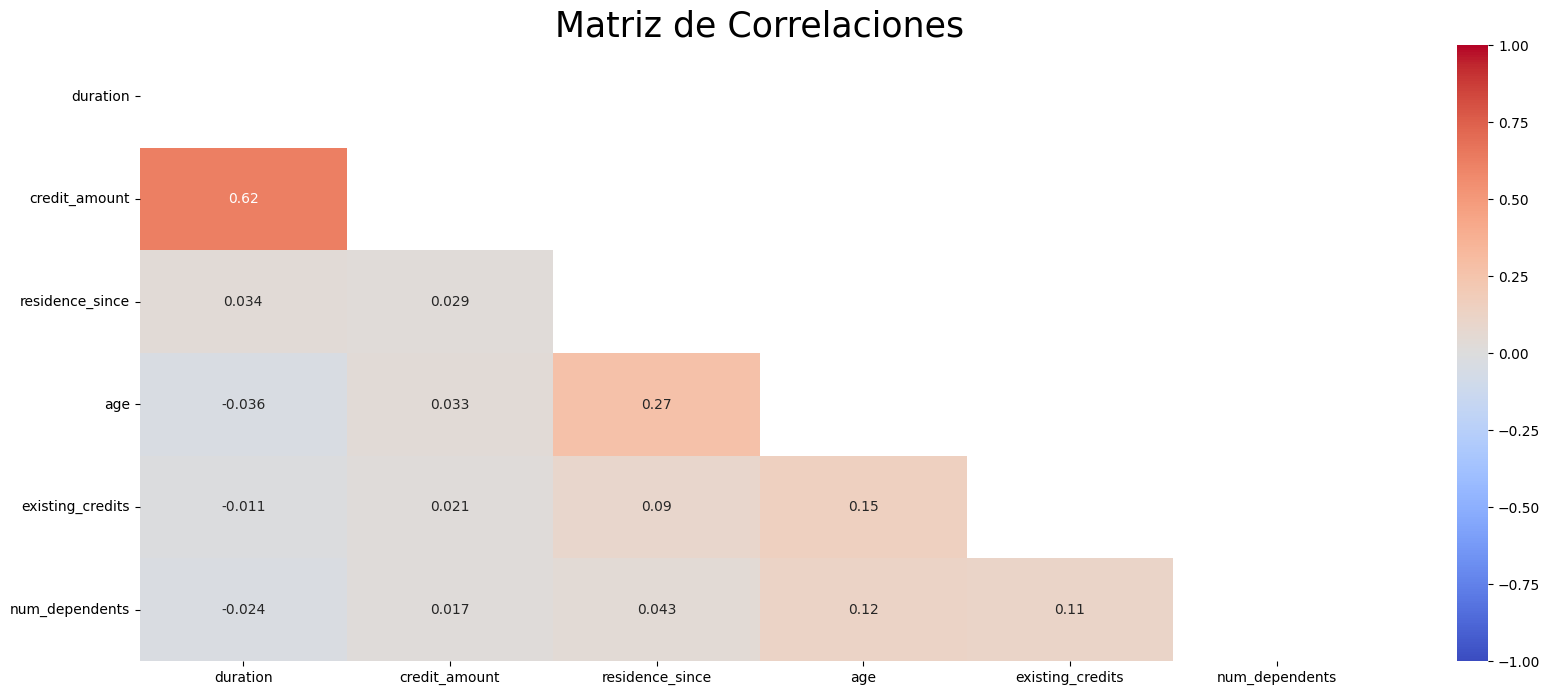

In [16]:
# df con variables numericas
df=datos.loc[:, lista_num] #vdf con variables numericas

# Tabla de correlaciones entre variables numéricas
matriz_cor=df.corr('pearson')  #correlación de pearson

# como cor(x,x)=1 y cor(x,y)=cor(y,x) se puede disponer solo de la diagonal inferior. 
# La siguiente función elimina la parte superior de la matriz de correlaciones
mask = np.zeros(matriz_cor.shape, dtype=bool)
mask[np.triu_indices(len(mask))] = True

plt.figure(figsize=(20,8)) #tamaño del gráfico
matriz=sns.heatmap(matriz_cor, annot = True, vmin = -1, vmax = 1, cmap = 'coolwarm', mask=mask) 
# cmap para elegir la gama de colores y vmin y vmax identificar todo el espectro de valores de la correlación de pearson [-1,1]
matriz.set_title('Matriz de Correlaciones',fontsize=25)
plt.show()

### Variables categóricas

Se obtiene la V de cramer

In [17]:
def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorical-categorical association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))


# Aplicación de la función
    
print('target_job:', cramers_corrected_stat(pd.crosstab(datos['target'], datos['job'])))
print('target_housing:', cramers_corrected_stat(pd.crosstab(datos['target'], datos['housing'])))
print('target_other_payment_plans:', cramers_corrected_stat(pd.crosstab(datos['target'], datos['other_payment_plans'])))
print('target_personal_status:', cramers_corrected_stat(pd.crosstab(datos['target'], datos['personal_status'])))
print('target_savings_status:', cramers_corrected_stat(pd.crosstab(datos['target'], datos['savings_status'])))
print('target_foreign_worker:', cramers_corrected_stat(pd.crosstab(datos['target'], datos['foreign_worker'])))
print('target_checking_status:', cramers_corrected_stat(pd.crosstab(datos['target'], datos['checking_status'])))
print('target_other_payment_plans:', cramers_corrected_stat(pd.crosstab(datos['target'], datos['other_payment_plans'])))
print('target_purpose:', cramers_corrected_stat(pd.crosstab(datos['target'], datos['purpose'])))
print('target_employment:', cramers_corrected_stat(pd.crosstab(datos['target'], datos['employment'])))
print('target_other_parties:', cramers_corrected_stat(pd.crosstab(datos['target'], datos['other_parties'])))
print('target_property_magnitude:', cramers_corrected_stat(pd.crosstab(datos['target'], datos['property_magnitude'])))
print('target_own_telephone:', cramers_corrected_stat(pd.crosstab(datos['target'], datos['own_telephone'])))
print('target_foreign_worker:', cramers_corrected_stat(pd.crosstab(datos['target'], datos['foreign_worker'])))

target_job: 0.0
target_housing: 0.12733448032933792
target_other_payment_plans: 0.10415394681626368
target_personal_status: 0.08129468862215453
target_savings_status: 0.17924029522149437
target_foreign_worker: 0.06946513621535383
target_checking_status: 0.3476189010590424
target_other_payment_plans: 0.10415394681626368
target_purpose: 0.1561148105809381
target_employment: 0.11991106245316734
target_other_parties: 0.06817636837744626
target_property_magnitude: 0.14400453584964393
target_own_telephone: 0.013104557655738317
target_foreign_worker: 0.06946513621535383


Además se realiza una agrupación de atributos de las variables categóricas que se incluyen en el modelo (para que sean significativas)

In [18]:
# purpose
datos['purpose'] = np.where(datos['purpose']=="'new car'", "'new car'", 'other')
# savings_status
datos['savings_status'] = np.where(datos['savings_status']=='<100', '<100', 'unknown/other')
# other_parties
datos['other_parties'] = np.where(datos['other_parties'] == 'guarantor', 'guarantor', 'co applicant/none')
# credit_history
g = ["'critical/other existing credit'", "'delayed previously'"]
datos['credit_history'] = np.where(~datos['credit_history'].isin(g), 'other', datos['credit_history'])
# employment
g = ['4<=X<7', 'unemployed']
datos['employment'] = np.where(~datos['employment'].isin(g), 'other', datos['employment'])
# property_magnitude
g = ["'no known property'", "'real_estate'"]
datos['property_magnitude'] = np.where(~datos['property_magnitude'].isin(g), 'car/life_insurance', 
                                   datos['property_magnitude'])
# housing
g = ["'for free'", 'own']
datos['housing'] = np.where(datos['housing'].isin(g), 'other', datos['housing'])
# other_payment_plans
g = ['none', 'stores']
datos['other_payment_plans'] = np.where(datos['other_payment_plans'].isin(g), 'other', datos['other_payment_plans'])

# Modelización (regresión logística)

In [19]:
# Matriz de datos sin la variable dependiente
X = datos.drop(columns=["target"])
# A todas las variables las convertimos en variables dummy: toman valores 0 o 1
X_d = pd.get_dummies(X, drop_first=True, dtype="int") # importante el argumento "dtypes" porque la última versión de pandas lo tiene, por defecto, como bool
# Añdimos una columnas de unos para la estimación del intercepto
X_d = sm.add_constant(X_d)

y = datos[["target"]]

logit_matrix = sm.GLM(target, X_d, family=sm.families.Binomial()).fit()

NameError: name 'target' is not defined

In [ ]:
logit_matrix.summary()

## Predicción del modelo y bondad de ajuste

En este caso se utiliza la matriz de confusión

In [ ]:
pred = pd.DataFrame(logit_matrix.predict(X_d), columns=['prediccion'])  #predicción con los datos utilizados para crear el modelo
df = pd.concat([target, pred], axis=1) #data.frame respuesta y predicción

# Matriz de confusión
df=pd.concat([target, pred], axis=1) #data.frame respuesta y predicción
df['prediccion']=np.where(df['prediccion'] > 0.5, 1, 0)

# Matriz_confusion_prob=pd.crosstab(df['target'], df['prediccion']).apply(lambda p: p/p.sum(), axis=0)
matriz_confusion_prob = pd.crosstab(df['target'], df['prediccion']).apply(lambda p: p/p.sum(), axis=1)

sns.heatmap(matriz_confusion_prob, annot = True, cmap = "coolwarm", fmt=".3")
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Target')
plt.show()

También podemos analizar otras métricas para evaluar los modelos como la precisión, el recall y el f1-score:

In [ ]:
print(classification_report(df['target'], df['prediccion']))